# (Kernel) Ridge Regression
Download the Spotify Tracks Dataset and perform ridge regression to predict the tracks’ popularity. Note that this dataset contains both numerical and categorical features. The student is thus required to follow these guidelines:
- first, train the model using only the numerical features,
- second, appropriately handle the categorical features (for example, with one-hot encoding or other techniques) and use them together with the numerical ones to train the model, in both cases, experiment with different training parameters, 
- use 5-fold cross validation to compute your risk estimates, thoroughly discuss and compare the performance of the model

The student is required to implement from scratch (without using libraries, such as Scikit-learn) the code for the ridge regression, while it is not mandatory to do so for the implementation of the 5-fold cross-validation.

Optional: Instead of regular ridge regression, implement kernel ridge regression using a Gaussian kernel.


# Initialization


In [1]:
if "google.colab" in str(get_ipython()):
    !git clone https://github.com/lukebella/SpotifyRegression.git
    !mv SpotifyRegression/* .
    !rm -fr SpotifyRegression

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = "xxxxxx" # insert here your kaggle username
os.environ['KAGGLE_KEY'] = "xxxxxx"      # insert here your kaggle key
!kaggle datasets download -p ./data -d maharshipandya/-spotify-tracks-dataset
!unzip -n ./data/-spotify-tracks-dataset.zip -d ./data

zsh:1: command not found: kaggle
unzip:  cannot find or open ./data/-spotify-tracks-dataset.zip, ./data/-spotify-tracks-dataset.zip.zip or ./data/-spotify-tracks-dataset.zip.ZIP.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [4]:
# Open the dataset
dataset_file = "data/dataset.csv"

dataset_df = pd.read_csv(dataset_file).drop(columns='Unnamed: 0')
dataset_df = dataset_df.sample(frac=1, random_state=0).dropna()

dataset_df

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
94264,55swcR1hqOlJ45RNoamfDH,Powfu;KNOWN.,tell me your feelings and i won't tell you mine,soda stream sky (feat. KNOWN),52,224825,True,0.609,0.394,0,-10.142,1,0.2090,0.757000,0.000340,0.1270,0.191,172.031,4,sad
6236,4DxJKxGAJMus7zVDOGI3Ab,Summoning,Lugburz,Flight of the Nazgul,20,427000,False,0.110,0.951,9,-9.627,0,0.2620,0.013000,0.384000,0.0626,0.054,76.699,4,black-metal
56,7lLKxcNeJtDTWVRKHovLEC,Aron Wright,Build It Better,Build It Better,51,234473,False,0.526,0.333,4,-13.020,1,0.0314,0.910000,0.168000,0.1110,0.159,94.951,4,acoustic
44601,1euszbbvkUzQzIhZUWFmXG,Highly Suspect,The Boy Who Died Wolf,My Name Is Human,64,258773,True,0.515,0.698,2,-5.572,0,0.0279,0.000057,0.000086,0.0827,0.194,139.960,4,grunge
112474,3aSrj9NKKBlZ3PSg2PFB17,Allame,Toprak,Toprak,40,186283,False,0.770,0.825,7,-4.985,1,0.1960,0.302000,0.000000,0.3620,0.651,136.046,4,turkish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,3lpmIoqpJmiY074Kay62SW,Yemi Alade,Africa Rising Vol.4,Home,0,224000,False,0.555,0.820,7,-2.663,1,0.0782,0.121000,0.000004,0.1290,0.968,113.000,4,dancehall
45891,3V4InT51kenWLTfXC6PfYr,Sonny Chillingworth,"Hawaiian Slack Key Guitar Masters, Vol. 2",Liloa's Mele - Grandson's Lullaby,21,166573,False,0.448,0.150,0,-22.779,1,0.0385,0.772000,0.885000,0.1190,0.125,93.857,4,guitar
42613,1eWNzbwzDFyQ7WTWAWZbnK,Nasum,Helvete,Slaves To the Grind,12,71240,True,0.239,0.961,1,-5.569,1,0.1850,0.000004,0.151000,0.3220,0.210,121.329,5,grindcore
43567,3NiB3v3elOuAy4Ij51F4Sl,Maur,Deep Inside,Deep Inside,62,202633,False,0.637,0.936,11,-5.274,0,0.0371,0.046500,0.000150,0.1040,0.497,126.027,3,groove


# Split the dataset

In [5]:
# Normalize loudness, tempo, duration_ms
loudness_norm = dataset_df["loudness"]
tempo_norm = dataset_df["tempo"]
duration_norm = dataset_df["duration_ms"]
#popularity_norm = dataset_df["popularity"]

tempo_norm = tempo_norm/tempo_norm.max(axis=0)
duration_norm = duration_norm/duration_norm.max(axis=0)
#popularity_norm = popularity_norm/popularity_norm.max(axis=0)

min_loud = abs(loudness_norm.min(axis=0))
max_loud = abs(loudness_norm.max(axis=0))

loudness_norm = (min_loud+loudness_norm)/(min_loud+max_loud)

dataset_df["loudness"] = loudness_norm
dataset_df["tempo"] = tempo_norm
dataset_df["duration_ms"] = duration_norm
#dataset_df["popularity"] = popularity_norm

In [6]:
# Create a DataFrame with only track_id and track_genre one-hot encoded
track_genre_df = pd.get_dummies(dataset_df[["track_id", "track_genre"]], columns=['track_genre'], dtype=int)

# Merge the track with the same id
track_genre_df = track_genre_df.groupby("track_id", as_index=False)[[i for i in track_genre_df.columns if i.startswith("track_genre_")]].agg(np.sum)

# Create a partial DataFrame with all feature except track_genre
partial_df = pd.get_dummies(dataset_df.drop(columns=["artists", "album_name", "track_name", 'track_genre']),
                            columns=['explicit', 'key', 'mode', 'time_signature'], dtype=int) \
               .drop_duplicates(subset=['track_id'])

# Merge partial_df and track_genre_df to create the new dataset
categorical_df = pd.merge(partial_df, track_genre_df, on=['track_id'], how='inner').drop(columns="track_id")

# Removed explicit_False because haveing explicit_True this features is useless
categorical_df = categorical_df.drop(columns=["explicit_False"])
categorical_df = categorical_df.rename(columns={"explicit_True": "explicit"})

for i in categorical_df.columns:
    categorical_df[i] = categorical_df[i]*100

categorical_df["popularity"] = categorical_df["popularity"]/100 

categorical_df

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,52.0,4.292769,60.9,39.4,72.857592,20.90,75.700000,0.034000,12.70,19.1,...,0,0,0,0,0,0,0,0,0,0
1,20.0,8.153064,11.0,95.1,73.810184,26.20,1.300000,38.400000,6.26,5.4,...,0,0,0,0,0,0,0,0,0,0
2,51.0,4.476987,52.6,33.3,67.534173,3.14,91.000000,16.800000,11.10,15.9,...,0,0,0,0,0,0,0,0,0,0
3,64.0,4.940967,51.5,69.8,81.310693,2.79,0.005710,0.008640,8.27,19.4,...,0,0,0,0,0,0,0,0,0,0
4,40.0,3.556855,77.0,82.5,82.396463,19.60,30.200000,0.000000,36.20,65.1,...,0,0,0,0,0,0,0,0,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,46.0,3.565944,56.5,63.0,80.496828,3.98,30.600000,0.000000,74.40,49.9,...,0,0,0,0,0,0,0,0,0,0
89736,27.0,5.193521,54.6,71.6,74.953295,5.83,60.300000,0.000000,2.60,91.3,...,0,0,0,0,0,0,0,0,0,0
89737,0.0,4.277017,55.5,82.0,86.691453,7.82,12.100000,0.000449,12.90,96.8,...,0,0,0,0,0,0,0,0,0,0
89738,21.0,3.180516,44.8,15.0,49.483011,3.85,77.200000,88.500000,11.90,12.5,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Create a mask to split the dataset into training set and test set
np.random.seed(0)
mask = np.random.rand(len(categorical_df))<0.7

In [8]:
# Categorical features
train_cat_df = categorical_df[mask]
test_cat_df = categorical_df[~mask]

In [9]:
# Numerical features
numerical_df = categorical_df[["popularity", "duration_ms", "danceability", "energy", "loudness",
                               "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]]

train_num_df = numerical_df[mask]
test_num_df = numerical_df[~mask]


In [10]:
#Generate different seeds in order to see how much variance occurs 

num_test = 3
num_dataset_list = []
cat_dataset_list = []

for i in range(num_test):
    np.random.seed(i)
    mask = np.random.rand(len(categorical_df))<0.7
    
    num_dataset_list.append((numerical_df[mask], numerical_df[~mask]))
    
    cat_dataset_list.append((categorical_df[mask], categorical_df[~mask]))

np.random.seed(0)

# Ridge Regression
Functions that implement the ridge regression prediction.

In [11]:
# Create the hyperplane using regular ridge regression
def ridge_regression(alpha, train_set):
    y = train_set[["popularity"]]
    train_set = train_set.drop(columns='popularity')
    n_rows, n_cols = train_set.shape  # Get the dimensions of the input matrix s
    s_t = train_set.transpose()  # Transpose of matrix s
    
    # Calculate the identity matrix with the appropriate size
    identity = np.identity(n_cols)
    
    # Calculate the ridge regression coefficients using matrix operations
    w = (np.linalg.pinv(alpha * identity + np.dot(s_t, train_set)).dot(s_t)).dot(y) 
    
    # Convert the coefficients to a DataFrame for better presentation
    w_df = pd.DataFrame(w, columns=["Values"], index=train_set.columns)
    
    return w_df

In [12]:
# Predict the popularity of a track x using an hyperplane w
def predict(w, x):
    pred = w.transpose().dot(x.drop(labels='popularity'))[0]
    return pred

In [13]:
# Compute the average square loss of the hyperplane w
def avg_square_loss(w, test_set):
    y = test_set[["popularity"]]
    test_set = test_set.drop(columns='popularity')
    # Convert the DataFrame to a numpy array
    x = test_set.values  
    # Calculate predictions for all rows at once
    predictions = np.dot(x, w)
    
    squared_diff = (predictions -  y)**2
    total_loss = np.sum(squared_diff)
    return total_loss.values[0]/test_set.shape[0]

## Ridge Regression using only numerical features

In [14]:
# Compute the MSE for each alpha in a range
alphas = 10**np.linspace(10, -2, 100)*0.5

num_train_losses = []
num_test_losses = []

for a in alphas:
    ridge = ridge_regression(a, train_num_df)
    num_train_losses.append(avg_square_loss(ridge, train_num_df))
    num_test_losses.append(avg_square_loss(ridge, test_num_df))

## Scikitlearn Ridge regression on numerical features


In [15]:
#Scikitlearn Ridge regression (for plot)
alphas = 10**np.linspace(10, -2, 100)*0.5

sk_num_train_losses = []
sk_num_test_losses = []

for a in alphas:
    clf = Ridge(alpha = a)
    clf.fit(train_num_df.drop(columns='popularity'), train_num_df['popularity'])
    sk_num_train_losses.append(mean_squared_error(train_num_df['popularity'], clf.predict(train_num_df.drop(columns='popularity'))))
    sk_num_test_losses.append(mean_squared_error(test_num_df['popularity'], clf.predict(test_num_df.drop(columns='popularity'))))

## Ridge regression on all features

In [16]:
alphas = 10**np.linspace(10, -2, 100)*0.5

cat_train_losses = []
cat_test_losses = []

for a in alphas:
    ridge = ridge_regression(a, train_cat_df)
    cat_train_losses.append(avg_square_loss(ridge, train_cat_df))
    cat_test_losses.append(avg_square_loss(ridge, test_cat_df))


## ScikitLearn Ridge regression on all features

In [17]:
alphas = 10**np.linspace(10, -2, 100)*0.5

sk_cat_train_losses = []
sk_cat_test_losses = []

for a in alphas:
    clf = Ridge(alpha = a)
    clf.fit(train_cat_df.drop(columns='popularity'), train_cat_df['popularity'])
    sk_cat_train_losses.append(mean_squared_error(train_cat_df['popularity'], clf.predict(train_cat_df.drop(columns='popularity'))))
    sk_cat_test_losses.append(mean_squared_error(test_cat_df['popularity'], clf.predict(test_cat_df.drop(columns='popularity'))))


## Compare between Numerical features and All features

Text(0.5, 1.0, 'ScikitLearn')

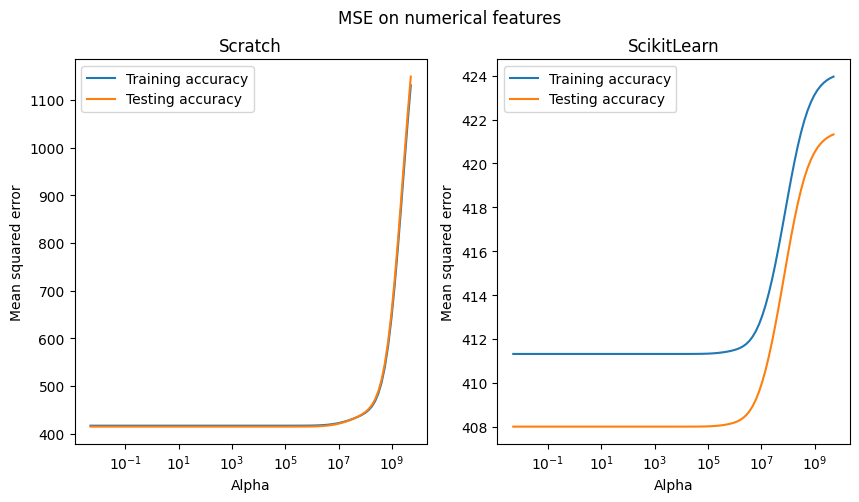

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('MSE on numerical features')
fig.set_size_inches(10,5)

ax1.plot(alphas, num_train_losses, label='Training accuracy')
ax1.plot(alphas, num_test_losses, label='Testing accuracy')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Mean squared error')
ax1.legend()
ax1.set_title("Scratch")

ax2.plot(alphas, sk_num_train_losses, label='Training accuracy')
ax2.plot(alphas, sk_num_test_losses, label='Testing accuracy')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('Mean squared error')
ax2.legend()
ax2.set_title("ScikitLearn")


Text(0.5, 1.0, 'ScikitLearn')

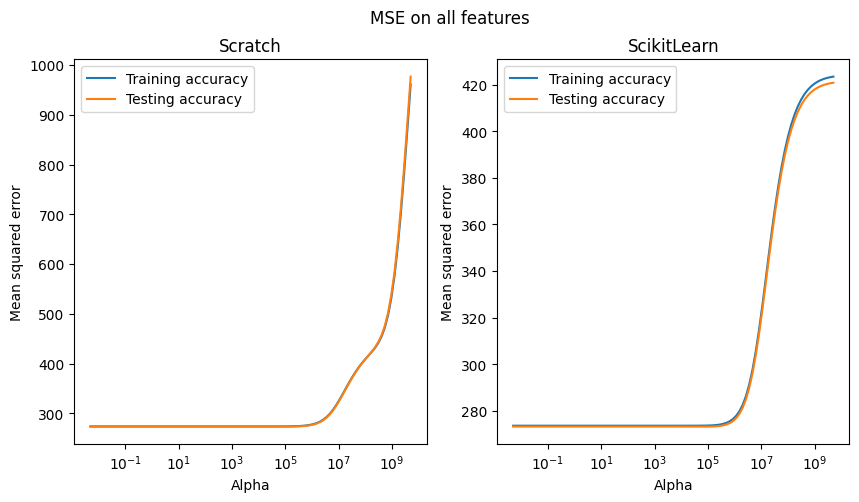

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('MSE on all features')
fig.set_size_inches(10, 5)

ax1.plot(alphas, cat_train_losses, label='Training accuracy')
ax1.plot(alphas, cat_test_losses, label='Testing accuracy')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Mean squared error')
ax1.legend()
ax1.set_title("Scratch")

ax2.plot(alphas, sk_cat_train_losses, label='Training accuracy')
ax2.plot(alphas, sk_cat_test_losses, label='Testing accuracy')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha')
ax2.set_ylabel('Mean squared error')
ax2.legend()
ax2.set_title("ScikitLearn")


# Linear regression
When we put `alpha=0` in the ridge regression function it becomes a linear predictor

### Numerical features

In [20]:
lin_num_result = []

for ds in num_dataset_list:
    # Compute the hyperplane for the numerical dataset
    result_numeric = ridge_regression(0, ds[0]) # alpha = 0 --> linear regression

    # Predicting by taking a row of the training set
    datapoint = ds[0].iloc[0]

    # Compute the Average square loss of the hyperplane (numerical)
    lin_num_result.append(avg_square_loss(result_numeric, ds[1]))

print(f"List results:\t{lin_num_result}")
print(f"Mean:\t\t{np.mean(lin_num_result)}")
print(f"std:\t\t{np.std(lin_num_result)}")
print(f"variance:\t{np.var(lin_num_result)}")

List results:	[414.7969798711408, 422.21876618971976, 413.02492361338324]
Mean:		416.680223224748
std:		3.9825987726854586
variance:	15.861092984195722


In [21]:
sk_lin_num_result = []

for ds in num_dataset_list:
    clf = Ridge(alpha=0)
    clf.fit(ds[0].drop(columns='popularity'), ds[0]['popularity'])
    sk_lin_num_result.append(mean_squared_error(ds[1]['popularity'], clf.predict(ds[1].drop(columns='popularity'))))

print(f"List results:\t{sk_lin_num_result}")
print(f"Mean:\t\t{np.mean(sk_lin_num_result)}")
print(f"std:\t\t{np.std(sk_lin_num_result)}")
print(f"variance:\t{np.var(sk_lin_num_result)}")

List results:	[408.0086604868272, 416.00695032348017, 408.0180517181412]
Mean:		410.67788750948284
std:		3.7682184035653785
variance:	14.19946993696881


In [22]:
# Compute the hyperplane for the numerical dataset
result_numeric = ridge_regression(0, train_num_df) # alpha = 0 --> linear regression

# Predicting by taking a row of the training set
datapoint = train_num_df.iloc[0]
predicted_y = predict(result_numeric, datapoint)

print(f"Predicted y: \t{predicted_y}")
print(f"Real y: \t{datapoint['popularity']}")

# Compute the Average square loss of the hyperplane (numerical)
print(f"Average square loss: \t{avg_square_loss(result_numeric, test_num_df)}")

#0.04147969798711406

Predicted y: 	37.70649504797049
Real y: 	52.0
Average square loss: 	414.7969798711408


In [23]:
clf = Ridge(alpha=0)
clf.fit(train_num_df.drop(columns='popularity'), train_num_df['popularity'])
mean_squared_error(test_num_df['popularity'], clf.predict(test_num_df.drop(columns='popularity')))

408.0086604868272

### All features

In [24]:
lin_cat_result = []

for ds in cat_dataset_list:
    # Compute the hyperplane for the numerical dataset
    result_numeric = ridge_regression(0, ds[0]) # alpha = 0 --> linear regression

    # Predicting by taking a row of the training set
    datapoint = ds[0].iloc[0]

    # Compute the Average square loss of the hyperplane (numerical)
    lin_cat_result.append(avg_square_loss(result_numeric, ds[1]))

print(f"List results:\t{lin_cat_result}")
print(f"Mean:\t\t{np.mean(lin_cat_result)}")
print(f"std:\t\t{np.std(lin_cat_result)}")
print(f"variance:\t{np.var(lin_cat_result)}")

List results:	[273.341721306556, 282.6412846985491, 269.1174077016734]
Mean:		275.03347123559286
std:		5.649207945865977
variance:	31.913550415635296


In [25]:
sk_lin_cat_result = []

for ds in cat_dataset_list:
    clf = Ridge(alpha=0)
    clf.fit(ds[0].drop(columns='popularity'), ds[0]['popularity'])
    sk_lin_cat_result.append(mean_squared_error(ds[1]['popularity'], clf.predict(ds[1].drop(columns='popularity'))))

print(f"List results:\t{sk_lin_cat_result}")
print(f"Mean:\t\t{np.mean(sk_lin_cat_result)}")
print(f"std:\t\t{np.std(sk_lin_cat_result)}")
print(f"variance:\t{np.var(sk_lin_cat_result)}")

List results:	[273.330698157547, 282.6219498310755, 272.7911252187512]
Mean:		276.24792440245784
std:		4.51249634257049
variance:	20.362623241712043


In [26]:
# Compute the hyperplane for the categorical dataset
result_categoric = ridge_regression(0, train_cat_df) # alpha = 0 --> linear regression

# Predicting by taking a row of the training set
datapoint = train_cat_df.iloc[0]
predicted_y = predict(result_categoric, datapoint)

print(f"Predicted y: \t{predicted_y}")
print(f"Real y: \t{datapoint['popularity']}")

# Compute the Average square loss of the hyperplane (categorical)
print("Average square loss: ", avg_square_loss(result_categoric, test_cat_df))

Predicted y: 	48.42258413624583
Real y: 	52.0
Average square loss:  273.341721306556


In [27]:
clf = Ridge(alpha=0)
clf.fit(train_cat_df.drop(columns='popularity'), train_cat_df['popularity'])
mean_squared_error(test_cat_df['popularity'], clf.predict(test_cat_df.drop(columns='popularity')))

273.330698157547

# (Nested) Cross Validation

In [28]:
def cross_validation(k, dataset, alphas):

    # Return a df from an arraty of df excepr the i-th
    def get_set_except_i(dataset_array, i):
        return pd.concat(dataset_array[j] for j in range(len(dataset_array)) if i!=j)
    
    # Split the dataset into k parts
    dataset_array = np.array_split(dataset, k)
    
    losses = []
    best_alphas = []

    for i in range(k):
        # In the i-th iteration, Si is the test and S\Si is the training
        test_cv = dataset_array[i] #1/k
        train_cv = get_set_except_i(dataset_array, i) #1 - 1/k
        nested_cv_array = np.array_split(train_cv, k)

        # Find the best hyperparameter of your alphas
        loss = float("inf")
        alpha = 0
        for a in alphas:
            nested_loss_list = []
            for j in range(k):
                # Split the training set into a new training set and a valid set (nested CV)
                nested_dev_cv = nested_cv_array[j]
                nested_train_cv = get_set_except_i(nested_cv_array, j)
                predictor = ridge_regression(a, nested_train_cv)
                nested_loss_list.append(avg_square_loss(predictor, nested_dev_cv))

            local_loss = np.mean(nested_loss_list)
            
            if loss > local_loss:
                loss = local_loss
                alpha = a
                
        # Compute k predictors and their losses
        prediction = ridge_regression(alpha, train_cv)
        best_alphas.append(alpha)
        losses.append(avg_square_loss(prediction, test_cv))

    #Find the avg loss of the predictors
    ind = losses.index(min(losses))
    return np.mean(losses), best_alphas[ind]

## Scratch Ridge CV

In [29]:
K = 5
alphas = 10**np.linspace(10, -2, 100)*0.5
loss_cv, a_cv = cross_validation(K, categorical_df[:1000], alphas)  #decrease the num of rows of categorical_df
print("Average loss with nested CV: ", loss_cv)
print("Best alpha with nested CV: ", a_cv)

Average loss with nested CV:  368.9683061928411
Best alpha with nested CV:  40556.54153948436


In [30]:
#Experiment with alpha achieved by CV
prediction = ridge_regression(a_cv, train_cat_df.sample(7500, random_state=0))
print(avg_square_loss(prediction, test_cat_df.sample(2500, random_state=0)))

292.09172533921674


## ScikitLearn Ridge CV

In [31]:
alphas = 10**np.linspace(10, -2, 100)*0.5

clf = RidgeCV(alphas=alphas, cv=5)
clf.fit(categorical_df.drop(columns='popularity'),categorical_df['popularity'])

sk_loss_cv = mean_squared_error(categorical_df['popularity'], clf.predict(categorical_df.drop(columns='popularity')))
sk_loss_cv


273.35655020392556

# Kernel Ridge Regression


Function that calculates the average distance of the first n datapoints.

In [32]:
def avg_norm(dataset, n_samples):
    d = dataset.sample(n=n_samples, random_state=0).values
    norm = 0
    n = 0
    for i in range(n_samples):
        for j in range(i+1,n_samples):
            n+=1
            norm += (np.linalg.norm(d[i] - d[j]))**2
            
    return norm/n

In [33]:
norm_list = []
for i in [100, 500, 1000, 5000, 10000]:
    norm_list.append(avg_norm(categorical_df, i))

avg_gamma = norm_list[-1]
norm_list

[71913.0352656894,
 68506.528238592,
 68946.14988342467,
 68477.52628531809,
 68300.24422713302]

|Samples|Average Norm|
|-|-|
|100|71913 |
|500|68506 |
|1000|68946|
|5000|68477|
|10000|68300|


## Kernel functions based on Gaussian kernel

In [34]:
def gaussian_kernel(gamma, v1, v2):
    norm = np.square(np.linalg.norm(v1 - v2))
    return np.exp((norm)/-(2 * (gamma)))


def kernel_ridge_regression(dataset, alpha, gamma):
    y = dataset["popularity"]
    dataset_values = dataset.drop(columns='popularity').values
    n_samples = dataset.shape[0]

    kernel = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i, n_samples):
            kernel[i, j] = gaussian_kernel(gamma, dataset_values[i], dataset_values[j])

    # we consider half of the datapoints since it is the 'symmetric'
    kernel = np.triu(kernel, 1) + kernel.transpose()
    
    identity = np.identity(n_samples)

    # w = y.transpose() @ np.linalg.inv((alpha * identity + kernel)) 
    w = np.linalg.solve(alpha * identity + kernel, y)

    w_df = pd.DataFrame(w, columns=['weights'])
    return w_df


def kernel_predict(w, dataset, x, gamma):
    x_values = x.drop(labels='popularity').values
    dataset_values = dataset.drop(columns='popularity').values
    kernel_values = np.array([gaussian_kernel(gamma, x_values, x_i) for x_i in dataset_values])
    prediction = w['weights'] @ kernel_values
    return prediction


def kernel_avg_square_loss(w, train_set, test_set, gamma):
    y = test_set[["popularity"]]
    predictions = test_set.apply(lambda r: kernel_predict(w, train_set, r, gamma), 1)
    squared_diff = (predictions - y.transpose())**2
    return np.mean(squared_diff, axis=1)[0]


### Test Kernel only on numerical features

In [35]:
kernel_num_result = []

for ds in num_dataset_list:
    # Test kernel on numerical features
    train_set = ds[0].sample(7500, random_state=0)
    test_set = ds[1].sample(2500, random_state=0)
    
    # Take gamma as average distance
    gamma = avg_norm(train_set, train_set.shape[0])
    w = kernel_ridge_regression(train_set, 1, gamma)
    
    kernel_num_result.append(kernel_avg_square_loss(w, train_set, test_set, gamma))

print(f"List results:\t{kernel_num_result}")
print(f"Mean:\t\t{np.mean(kernel_num_result)}")
print(f"std:\t\t{np.std(kernel_num_result)}")
print(f"variance:\t{np.var(kernel_num_result)}")

List results:	[392.3796389712736, 398.66339152955396, 389.5254065855949]
Mean:		393.5228123621409
std:		3.8171390910118124
variance:	14.570550840130487


In [36]:
# Test kernel on numerical features
train_set = train_num_df.sample(7500, random_state=0)
test_set = test_num_df.sample(2500, random_state=0)
x = numerical_df.iloc[0]

# Take gamma as average distance
gamma = avg_norm(train_set, train_set.shape[0])
w = kernel_ridge_regression(train_set, 1, gamma)

print(x['popularity'])
print(kernel_predict(w, train_set, x, gamma))

kernel_loss = kernel_avg_square_loss(w, train_set, test_set, gamma)
print("AVG Square loss: ", kernel_loss)
print("AVG loss: ", kernel_loss**(1/2))

52.0
41.65114501917611
AVG Square loss:  392.3796389712736
AVG loss:  19.808574884914705


### Test Kernel on all features

In [37]:
kernel_cat_result = []

for ds in cat_dataset_list:
    # Test kernel on numerical features
    train_set = ds[0].sample(7500, random_state=0)
    test_set = ds[1].sample(2500, random_state=0)
    
    # Take gamma as average distance
    gamma = avg_norm(train_set, train_set.shape[0])
    w = kernel_ridge_regression(train_set, 1, gamma)
    
    kernel_cat_result.append(kernel_avg_square_loss(w, train_set, test_set, gamma))

print(f"List restults:\t{kernel_cat_result}")
print(f"Mean:\t\t{np.mean(kernel_cat_result)}")
print(f"std:\t\t{np.std(kernel_cat_result)}")
print(f"variance:\t{np.var(kernel_cat_result)}")

List restults:	[281.3018667901998, 274.46312171558907, 263.2577470380065]
Mean:		273.0075785145985
std:		7.4380337417597815
variance:	55.32434594355701


In [38]:
# Test kernel on all features
train_set = train_cat_df.sample(7500, random_state=0)
test_set = test_cat_df.sample(2500, random_state=0)
x = categorical_df.iloc[0]

gamma = avg_norm(train_set, train_set.shape[0])
w = kernel_ridge_regression(train_set, 1, gamma)

print(x['popularity'])
print(kernel_predict(w, train_set, x, gamma))

kernel_loss = kernel_avg_square_loss(w, train_set, test_set, gamma)
print("AVG Square loss: ", kernel_loss)
print("AVG loss: ", kernel_loss**(1/2))

52.0
52.85568102963468
AVG Square loss:  281.3018667901998
AVG loss:  16.77205612887698


## ScikitLearn Kernel Ridge regression (RBF)

If we want to set the same gaussian kernel function, we would pass the root square gamma

### Numerical

In [39]:
sk_kernel_train_num_result = []
sk_kernel_test_num_result = []

for ds in num_dataset_list:
    train_set = ds[0].sample(7500, random_state=0)
    test_set = ds[1].sample(2500, random_state=0)
    
    clf = KernelRidge(kernel=RBF(avg_gamma**(1/2)), alpha=1, gamma=avg_gamma)
    clf.fit(train_set.drop(columns='popularity'), train_set['popularity'])

    sk_kernel_train_num_result.append(mean_squared_error(train_set['popularity'], clf.predict(train_set.drop(columns='popularity'))))
    sk_kernel_test_num_result.append(mean_squared_error(test_set['popularity'], clf.predict(test_set.drop(columns='popularity'))))

print("Training results")
print(f"List results:\t{sk_kernel_train_num_result}")
print(f"Mean:\t\t{np.mean(sk_kernel_train_num_result)}")
print(f"std:\t\t{np.std(sk_kernel_train_num_result)}")
print(f"variance:\t{np.var(sk_kernel_train_num_result)}")

print("Testing results")
print(f"List results:\t{sk_kernel_test_num_result}")
print(f"Mean:\t\t{np.mean(sk_kernel_test_num_result)}")
print(f"std:\t\t{np.std(sk_kernel_test_num_result)}")
print(f"variance:\t{np.var(sk_kernel_test_num_result)}")

Training results
List results:	[402.85281326818443, 394.4587412570293, 407.7615951847181]
Mean:		401.6910499033106
std:		5.492646674863183
variance:	30.169167494885574
Testing results
List results:	[404.1891710664254, 406.6525307112592, 396.86610465870984]
Mean:		402.5692688121315
std:		4.156248003957742
variance:	17.274397470402718


In [40]:
# Scikitlearn Kernel Ridge regression on numerical features
train_set = train_num_df.sample(7500, random_state=0)
test_set = test_num_df.sample(2500, random_state=0)

clf = KernelRidge(kernel=RBF(avg_gamma**(1/2)), alpha=1, gamma=avg_gamma)
clf.fit(train_set.drop(columns='popularity'), train_set['popularity'])
sk_kernel_train_loss = mean_squared_error(train_set['popularity'], clf.predict(train_set.drop(columns='popularity')))
sk_kernel_test_loss = mean_squared_error(test_set['popularity'], clf.predict(test_set.drop(columns='popularity')))
print("Train ", sk_kernel_train_loss)
print("Test ", sk_kernel_test_loss)

Train  402.85281326818443
Test  404.1891710664254


### Categorical

In [41]:
sk_kernel_train_cat_result = []
sk_kernel_test_cat_result = []

for ds in cat_dataset_list:
    train_set = ds[0].sample(7500, random_state=0)
    test_set = ds[1].sample(2500, random_state=0)
    
    clf = KernelRidge(kernel=RBF(avg_gamma**(1/2)), alpha=1, gamma=avg_gamma)
    clf.fit(train_set.drop(columns='popularity'), train_set['popularity'])

    sk_kernel_train_cat_result.append(mean_squared_error(train_set['popularity'], clf.predict(train_set.drop(columns='popularity'))))
    sk_kernel_test_cat_result.append(mean_squared_error(test_set['popularity'], clf.predict(test_set.drop(columns='popularity'))))

print("Training results")
print(f"List results:\t{sk_kernel_train_cat_result}")
print(f"Mean:\t\t{np.mean(sk_kernel_train_cat_result)}")
print(f"std:\t\t{np.std(sk_kernel_train_cat_result)}")
print(f"variance:\t{np.var(sk_kernel_train_cat_result)}")

print("Testing results")
print(f"List results:\t{sk_kernel_test_cat_result}")
print(f"Mean:\t\t{np.mean(sk_kernel_test_cat_result)}")
print(f"std:\t\t{np.std(sk_kernel_test_cat_result)}")
print(f"variance:\t{np.var(sk_kernel_test_cat_result)}")

Training results
List results:	[237.3207702912004, 229.43850999008052, 244.41374457024708]
Mean:		237.05767495050932
std:		6.116443795293366
variance:	37.41088470098271
Testing results
List results:	[281.3058555833841, 274.42816183179275, 263.2180508952149]
Mean:		272.9840227701306
std:		7.454587975710107
variance:	55.5708818876017


In [42]:
# Scikitlearn Kernel Ridge regression on all features
train_set = train_cat_df.sample(7500, random_state=0)
test_set = test_cat_df.sample(2500, random_state=0)

clf = KernelRidge(kernel=RBF(avg_gamma**(1/2)), alpha=1, gamma=avg_gamma)
clf.fit(train_set.drop(columns='popularity'), train_set['popularity'])
sk_kernel_train_loss = mean_squared_error(train_set['popularity'], clf.predict(train_set.drop(columns='popularity')))
sk_kernel_test_loss = mean_squared_error(test_set['popularity'], clf.predict(test_set.drop(columns='popularity')))
print("Train ", sk_kernel_train_loss)
print("Test ", sk_kernel_test_loss)

Train  237.3207702912004
Test  281.3058555833841


## ScikitLearn Kernel Ridge regression (Linear)

### Numerical

In [43]:
# Scikitlearn Kernel Ridge regression on numerical features
train_set = train_num_df.sample(7500, random_state=0)
test_set = test_num_df.sample(2500, random_state=0)

clf = KernelRidge(alpha=1)
clf.fit(train_set.drop(columns='popularity'), train_set['popularity'])
sk_kernel_lin_train_loss = mean_squared_error(train_set['popularity'], clf.predict(train_set.drop(columns='popularity')))
sk_kernel_lin_test_loss = mean_squared_error(test_set['popularity'], clf.predict(test_set.drop(columns='popularity')))
print("Train ", sk_kernel_lin_train_loss)
print("Test ", sk_kernel_lin_test_loss)

Train  417.56792819712075
Test  422.7381725638246


### Categorical

In [44]:
# Scikitlearn Kernel Ridge regression on all features
train_set = train_cat_df.sample(7500, random_state=0)
test_set = test_cat_df.sample(2500, random_state=0)

clf = KernelRidge(alpha=1)
clf.fit(train_set.drop(columns='popularity'), train_set['popularity'])
sk_kernel_lin_train_loss = mean_squared_error(train_set['popularity'], clf.predict(train_set.drop(columns='popularity')))
sk_kernel_lin_test_loss = mean_squared_error(test_set['popularity'], clf.predict(test_set.drop(columns='popularity')))
print("Train ", sk_kernel_lin_train_loss)
print("Test ", sk_kernel_lin_test_loss)

Train  269.1032553788782
Test  291.2685628588211


## Kernel Cross Validation

In [45]:
# Generating the sets of hyperparameters
alphas = 10. ** np.arange(-2, 5)
gammas = np.logspace(1, 100, num=5, base=1.5)

In [46]:
def kernel_cross_validation(k, dataset, alpha, gammas):
    # Return a df from an arraty of df excepr the i-th
    def get_set_except_i(dataset_array, i):
        return pd.concat(dataset_array[j] for j in range(len(dataset_array)) if i!=j)

    # Split the dataset into k parts
    dataset_array = np.array_split(dataset, k)

    losses = []
    best_gammas= []

    for i in range(k):
        # In the i-th iteration, Si is the test and S\Si is the training
        test_cv = dataset_array[i]
        train_cv = get_set_except_i(dataset_array, i)

        # Split the training set into a new training set and a valid set (nested CV)
        nested_cv_array = np.array_split(train_cv, k)
        
        # Find the best hyperparameter of your gammas
        loss = float("inf")
        gamma = 0
        for g in gammas:
            nested_loss_list = []
            for j in range(k):
                nested_dev_cv = nested_cv_array[j]
                nested_train_cv = get_set_except_i(nested_cv_array, j)
                predictor = kernel_ridge_regression(nested_train_cv, alpha, g)
                nested_loss_list.append(kernel_avg_square_loss(predictor, nested_train_cv, nested_dev_cv, g))

            local_loss = np.mean(nested_loss_list)
            if loss > local_loss:
                loss = local_loss
                gamma = g

        # Compute k predictors and their losses
        prediction = kernel_ridge_regression(train_cv, alpha, gamma)
        best_gammas.append(gamma)
        losses.append(kernel_avg_square_loss(prediction, train_cv, test_cv, gamma))

    # Find the avg loss of the predictors
    ind = losses.index(min(losses))
    return np.mean(losses), best_gammas[ind]

### KCV on gammas

In [47]:
K = 5
kcv_size = 500
kcv_df = categorical_df.sample(kcv_size, random_state=0)
kernel_cv_losses = []
kernel_cv_gamma = []
for a in alphas:
    tmp = kernel_cross_validation(K, kcv_df, a, gammas)
    kernel_cv_losses.append(tmp[0])
    kernel_cv_gamma.append(tmp[2])

print(f"alphas: {alphas}")
print(f"gammas: {kernel_cv_gamma}")
print(f"losses: {kernel_cv_losses}")

alphas: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
gammas: [780923662.2761682, 780923662.2761682, 34225.50939597908, 34225.50939597908, 4.065611775352152e+17, 4.065611775352152e+17, 4.065611775352152e+17]
losses: [461.2962977873887, 466.4254869466343, 396.1994277264696, 417.7059687816134, 468.6194096000034, 946.459363877575, 1367.7979434282602]


In [48]:
# Retrieve the best alpha with its best corrispondent gamma
ind = kernel_cv_losses.index(min(kernel_cv_losses))
best_alpha = alphas[ind]
best_gamma = kernel_cv_gamma[ind]

print(f"Best alpha: {best_alpha}")
print(f"Best gamma: {best_gamma}")

Best alpha: 1.0
Best gamma: 34225.50939597908


In [49]:
# Train and test Kernel CV with bigger set sizes
train_cv = train_cat_df.sample(7500, random_state=0)
test_cv = test_cat_df.sample(2500, random_state=0)
prediction = kernel_ridge_regression(train_cv, best_alpha, best_gamma)
kcv_loss = kernel_avg_square_loss(prediction, train_cv, test_cv, best_gamma)
kcv_loss

276.1403232863619

Text(0.5, 1.0, 'Hyperparameter tuning in Kernel Ridge regression')

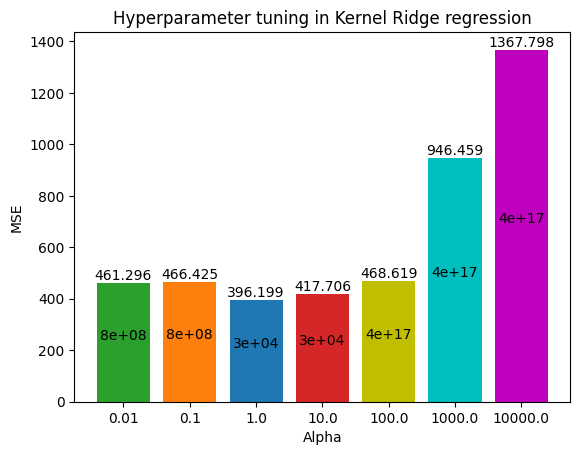

In [50]:
bar_alpha = [f'{i}' for i in alphas] 
bar_name = [str(i) for i in kernel_cv_gamma]
bar_value = kernel_cv_losses
bar_colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:red', 'y', 'c', 'm']

bars = plt.bar(bar_alpha, bar_value, label=bar_name, color=bar_colors)
for b in bars:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')
    plt.text(b.get_x() + b.get_width() / 2.0, height/2, f'{float(b.get_label()):.1}', ha='center', va='bottom')

plt.ylabel('MSE')
plt.xlabel('Alpha')
plt.title('Hyperparameter tuning in Kernel Ridge regression')

# CV vs. Kernel Ridge regression

In [53]:
# bar_name = ['CV_scratch', 'CV_SK']
# bar_value = [loss_cv, sk_loss_cv]
# bar_colors = ['tab:green', 'tab:orange']

# bars = plt.bar(bar_name, bar_value, label=bar_name, color=bar_colors)
# for b in bars:
#     height = b.get_height()
#     plt.text(b.get_x() + b.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
# plt.ylabel('MSE')
# plt.title('CV: scratch vs scikit-learn')
# plt.legend()


Text(0.5, 1.0, 'Kernel Ridge Regression: scratch vs scikit-learn')

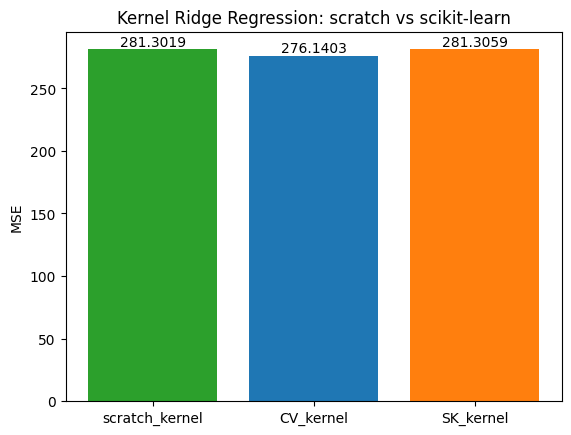

In [52]:
bar_name = ['scratch_kernel', 'CV_kernel', 'SK_kernel']
bar_value = [kernel_loss, kcv_loss, sk_kernel_test_loss]
bar_colors = ['tab:green', 'tab:blue', 'tab:orange']

bars = plt.bar(bar_name, bar_value, label=bar_name, color=bar_colors)
for b in bars:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
plt.ylabel('MSE')
plt.title('Kernel Ridge Regression: scratch vs scikit-learn')
# plt.legend()
